<a href="https://colab.research.google.com/github/CarolKSD/Forecasting_Stocks/blob/main/cleanspark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance
!pip install arch
!pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 11.4 MB/s eta 0:00:00


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model

In [38]:
# Step 1: Data Collection
def fetch_stock_data(ticker, start_date, end_date):
    return yf.download(ticker, start=start_date, end=end_date)

# Configuration
start_date = "2018-01-01"
end_date = "2024-12-31"
stock_ticker = "CLSK"
bitcoin_ticker = "BTC-USD"

# Fetch data for stock and Bitcoin
stock_data = fetch_stock_data(stock_ticker, start_date, end_date)
bitcoin_data = fetch_stock_data(bitcoin_ticker, start_date, end_date)

# Fill missing values
stock_data['Close'] = stock_data['Close'].fillna(method='ffill')
bitcoin_data['Close'] = bitcoin_data['Close'].fillna(method='ffill')

# Rename the Bitcoin 'Close' column to 'Bitcoin_Close'
bitcoin_data.rename(columns={'Close': 'Bitcoin_Close'}, inplace=True)

# Align both DataFrames by their indices
aligned_stock_data = stock_data[['Close']].rename(columns={'Close': 'Stock_Close'})
aligned_bitcoin_data = bitcoin_data[['Bitcoin_Close']]

# Combine aligned DataFrames into a single DataFrame
data = pd.concat([aligned_stock_data, aligned_bitcoin_data], axis=1)

# Drop rows with missing values
data.dropna(inplace=True)

# Display the first rows to ensure both columns exist
print(data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Price      Stock_Close Bitcoin_Close
Ticker            CLSK       BTC-USD
Date                                
2018-01-02        24.4  14982.099609
2018-01-03        24.4  15201.000000
2018-01-04        24.4  15599.200195
2018-01-05        24.4  17429.500000
2018-01-08        24.4  15170.099609



<ipython-input-38-5e9165c1af3a>:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['Close'] = stock_data['Close'].fillna(method='ffill')
<ipython-input-38-5e9165c1af3a>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bitcoin_data['Close'] = bitcoin_data['Close'].fillna(method='ffill')


In [39]:
data

Price,Stock_Close,Bitcoin_Close
Ticker,CLSK,BTC-USD
Date,,
2018-01-02,24.400,14982.099609
2018-01-03,24.400,15201.000000
2018-01-04,24.400,15599.200195
2018-01-05,24.400,17429.500000
2018-01-08,24.400,15170.099609
...,...,...
2024-12-20,11.140,97755.929688
2024-12-23,10.260,94686.242188


In [40]:
# Step 2: Feature Engineering
data['Daily_Returns'] = data['Stock_Close'].pct_change()
data['MA_10'] = data['Stock_Close'].rolling(window=10).mean()
data['MA_50'] = data['Stock_Close'].rolling(window=50).mean()

# Relative Strength Index (RSI)
def compute_RSI(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI'] = compute_RSI(data['Stock_Close'])
data.dropna(inplace=True)

In [41]:
data

Price,Stock_Close,Bitcoin_Close,Daily_Returns,MA_10,MA_50,RSI
Ticker,CLSK,BTC-USD,,,,
Date,,,,,,
2018-03-16,12.000,8338.349609,-0.245283,15.5100,20.4440,0.000000
2018-03-19,15.700,8630.650391,0.308333,15.4900,20.2700,48.684212
2018-03-20,15.700,8913.469727,0.000000,15.4700,20.0960,48.684212
2018-03-21,15.700,8929.280273,0.000000,15.4500,19.9220,48.684212
2018-03-22,15.700,8728.469727,0.000000,15.4300,19.7480,48.684212
...,...,...,...,...,...,...
2024-12-20,11.140,97755.929688,0.021082,12.1890,12.8856,29.638554
2024-12-23,10.260,94686.242188,-0.078995,11.8590,12.8990,28.571430


Price   Stock_Close  Bitcoin_Close Daily_Returns        MA_10        MA_50  \
Ticker         CLSK        BTC-USD                                           
count   1672.000000    1672.000000   1672.000000  1672.000000  1672.000000   
mean      12.883196   28997.111623      0.004840    12.897363    13.022021   
std       10.047616   22156.214158      0.130249     9.796226     9.273290   
min        1.050000    3242.484863     -0.521918     1.144000     1.521700   
25%        4.637500    9243.514160     -0.040799     4.655000     4.886865   
50%       10.625000   23685.160156     -0.002681    10.756750    10.651350   
75%       18.000000   43757.557617      0.034671    17.930500    17.694250   
max       73.000000  106140.601562      3.866667    55.495000    39.662800   

Price           RSI  
Ticker               
count   1672.000000  
mean      47.977716  
std       19.001514  
min        0.000000  
25%       34.035147  
50%       47.387411  
75%       60.475274  
max      100.000000  

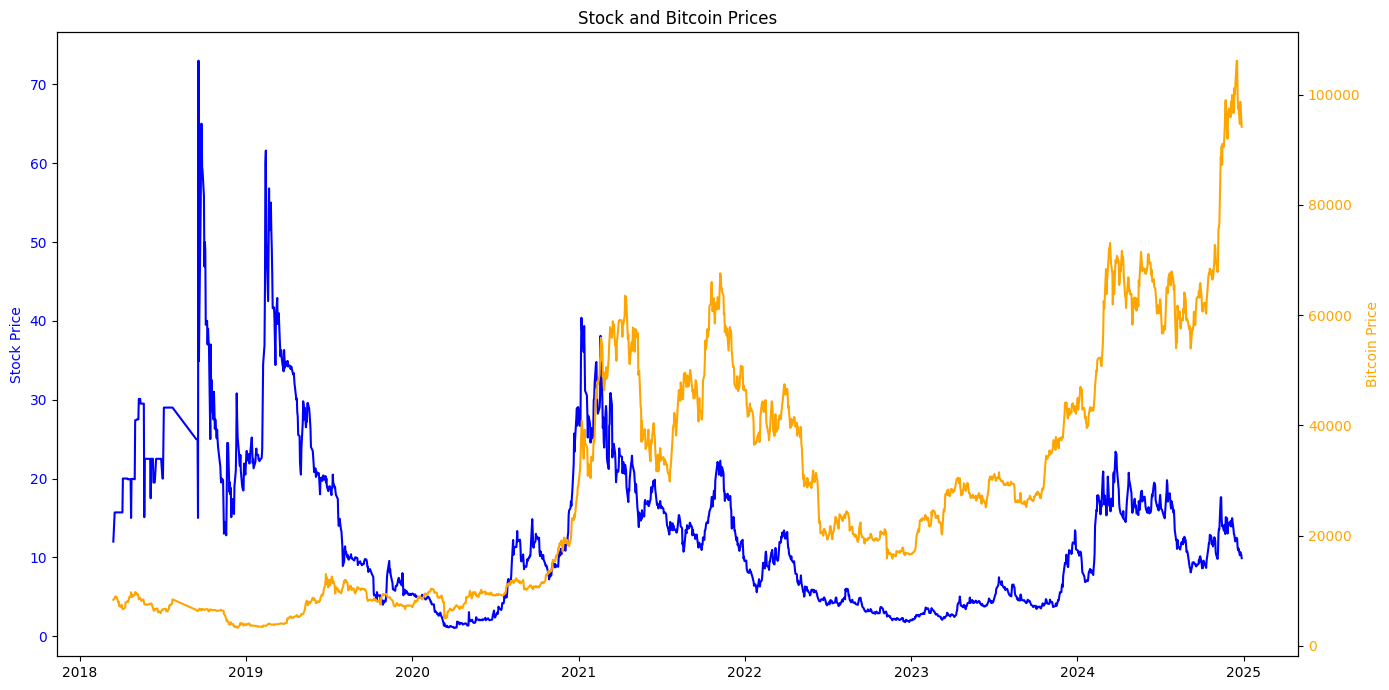

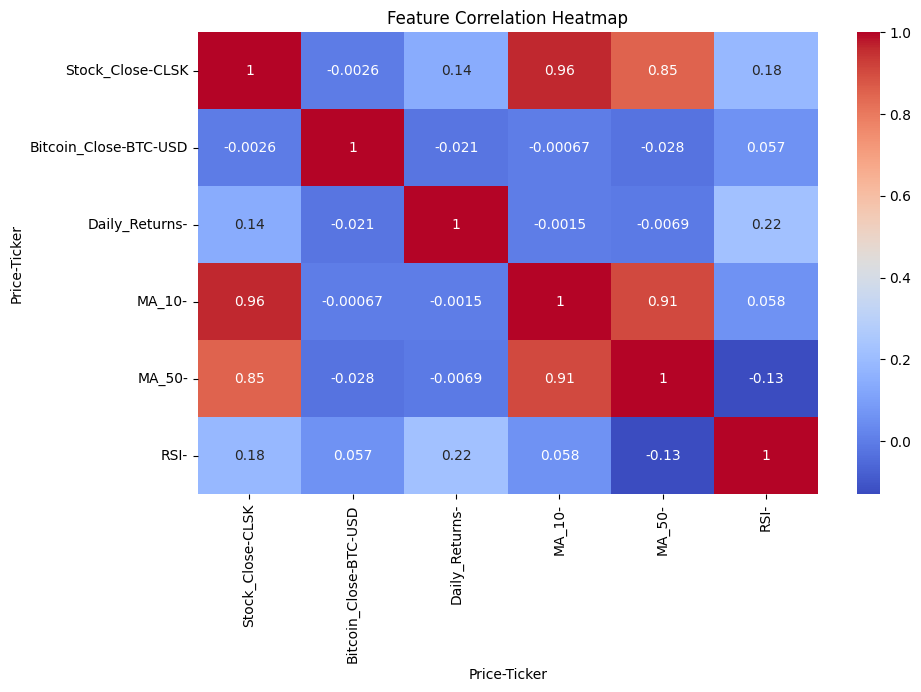

In [42]:
# Step 3: Exploratory Data Analysis (EDA)
print(data.describe())

# Dual axes for stock and Bitcoin prices
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Stock Price on the left y-axis
ax1.plot(data.index, data['Stock_Close'], color='blue', label='Stock Price')
ax1.set_ylabel('Stock Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Bitcoin Price on the right y-axis
ax2 = ax1.twinx()
ax2.plot(data.index, data['Bitcoin_Close'], color='orange', label='Bitcoin Price')
ax2.set_ylabel('Bitcoin Price', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Titles and legends
plt.title('Stock and Bitcoin Prices')
fig.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [43]:
# Step 4: Data Preprocessing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create time series windows
window_size = 60
X, y = [], []

for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i-window_size:i])
    y.append(scaled_data[i, 0])  # Target: Stock_Close

X, y = np.array(X), np.array(y)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [44]:
# Step 5: Statistical Model (ARIMA)
arima_train = data['Stock_Close'][:train_size]
arima_test = data['Stock_Close'][train_size:]

arima_model = ARIMA(arima_train, order=(5, 1, 0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(arima_test))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [45]:
# Step 6: Traditional Machine Learning Model (Random Forest)
X_rf_train = data.iloc[:train_size, 1:].values  # Exclude 'Stock_Close'
X_rf_test = data.iloc[train_size:, 1:].values
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_rf_train, arima_train.values)
rf_predictions = rf_model.predict(X_rf_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [46]:
# Step 7: Deep Learning Model (LSTM)
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# LSTM Predictions
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(
    np.concatenate([lstm_predictions, np.zeros((len(lstm_predictions), scaled_data.shape[1] - 1))], axis=1)
)[:, 0]

# Reverse scaling for the test set
y_test_original = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), scaled_data.shape[1] - 1))], axis=1)
)[:, 0]

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0098 - val_loss: 0.0023
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0022 - val_loss: 6.4664e-04
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0027 - val_loss: 6.5042e-04
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0018 - val_loss: 6.4752e-04
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0018 - val_loss: 4.7646e-04
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0012 - val_loss: 4.2915e-04
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 8.2543e-04 - val_loss: 4.2272e-04
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0012 - val_loss: 5.9150e-04
Epoch 11/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - loss: 0.0019 - val_loss: 7.0683e-04
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━━

In [47]:
# Step 8: Evaluate Models
models = {
    'ARIMA': arima_forecast,
    'Random Forest': rf_predictions,
    'LSTM': lstm_predictions
}

metrics = {}
for model_name, predictions in models.items():
    # Align prediction lengths with y_test_original for all models
    predictions = predictions[:len(y_test_original)]
    mae = mean_absolute_error(y_test_original, predictions)
    rmse = np.sqrt(mean_squared_error(y_test_original, predictions))
    metrics[model_name] = {'MAE': mae, 'RMSE': rmse}
    print(f"{model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

ARIMA - MAE: 7.61, RMSE: 8.88
Random Forest - MAE: 4.87, RMSE: 5.87
LSTM - MAE: 1.04, RMSE: 1.34


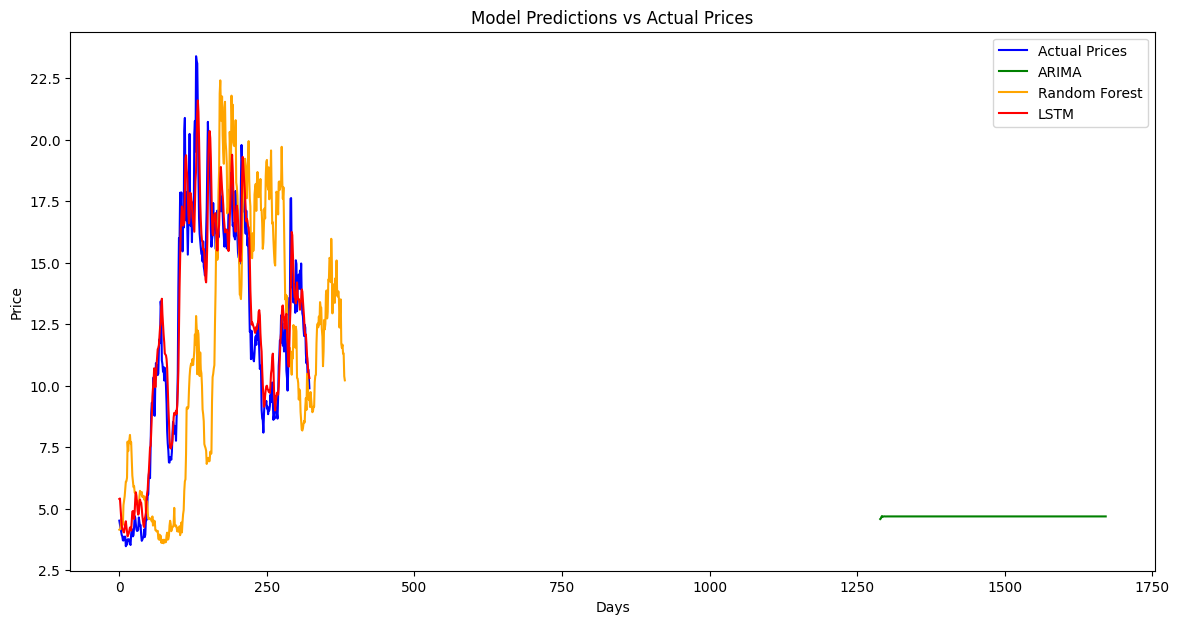

In [48]:
# Step 9: Visualize Results
plt.figure(figsize=(14, 7))
plt.plot(y_test_original, label='Actual Prices', color='blue')
plt.plot(arima_forecast, label='ARIMA', color='green')
plt.plot(rf_predictions, label='Random Forest', color='orange')
plt.plot(lstm_predictions, label='LSTM', color='red')
plt.title('Model Predictions vs Actual Prices')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

In [59]:
# Step 10: Predict Prices for the Next 30 Days (LSTM)
future_predictions = []
latest_data = scaled_data[-window_size:]  # Use the last `window_size` rows as the starting point

for _ in range(7):  # Predict for the next 30 days
    # Reshape the data for the LSTM model
    input_data = np.expand_dims(latest_data, axis=0)  # Shape: (1, window_size, features)

    # Predict the next day's price
    next_day_prediction = lstm_model.predict(input_data)  # Shape: (1, 1)

    # Inverse transform the prediction to get the original scale
    next_day_price = scaler.inverse_transform(
        np.concatenate([next_day_prediction, np.zeros((1, scaled_data.shape[1] - 1))], axis=1)
    )[:, 0][0]

    # Append the predicted price to the list
    future_predictions.append(next_day_price)

    # Scale the predicted price back for the model input
    next_day_scaled = scaler.transform(
        np.concatenate([next_day_prediction, np.zeros((1, scaled_data.shape[1] - 1))], axis=1)
    )  # Shape: (1, features)

    # Update latest_data by sliding the window and appending the new prediction
    latest_data = np.concatenate([latest_data[1:], next_day_scaled], axis=0)  # Shape: (window_size, features)

# Print the 30-day predictions
print("Next 30 Days Predicted Prices (LSTM):")
for day, price in enumerate(future_predictions, start=1):
    print(f"Day {day}: {price:.2f} USD")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Next 30 Days Predicted Prices (LSTM):
Day 1: 9.98 USD
Day 2: 7.83 USD
Day 3: 5.50 USD
Day 4: 3.56 USD
Day 5: 2.14 USD
Day 6: 1.21 USD
Day 7: 0.65 USD
